In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter

import argparse
from distutils.util import strtobool
import collections
import numpy as np
import gym
from gym.wrappers import TimeLimit, Monitor
from gym.spaces import Discrete, Box, MultiBinary, MultiDiscrete, Space
import time
import random
import os
import matplotlib.pyplot as plt
import time
import argparse
import datetime
from torch.distributions import Categorical, Normal

/opt/conda/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [2]:
class Buffer(object):
    """
    A buffer for storing trajectories experienced by a agent interacting
    with the environment.
    """

    def __init__(self, obs_dim, act_dim, size, device, gamma=0.99, lam=0.97):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.act_buf = np.zeros([size, act_dim], dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.don_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.v_buf = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.ptr, self.max_size = 0, size
        self.device = device

    def add(self, obs, act, rew, don, v):
        assert self.ptr < self.max_size      # Buffer has to have room so you can store
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.don_buf[self.ptr] = don
        self.v_buf[self.ptr] = v
        self.ptr += 1

    def finish_path(self):
        previous_v = 0
        running_ret = 0
        running_adv = 0
        for t in reversed(range(len(self.rew_buf))):
            # The next two line computes rewards-to-go, to be targets for the value function
            running_ret = self.rew_buf[t] + self.gamma*(1-self.don_buf[t])*running_ret
            self.ret_buf[t] = running_ret

            # The next four lines implement GAE-Lambda advantage calculation
            running_del = self.rew_buf[t] + self.gamma*(1-self.don_buf[t])*previous_v - self.v_buf[t]
            running_adv = running_del + self.gamma*self.lam*(1-self.don_buf[t])*running_adv
            previous_v = self.v_buf[t]
            self.adv_buf[t] = running_adv
        # The next line implement the advantage normalization trick
        self.adv_buf = (self.adv_buf - self.adv_buf.mean()) / self.adv_buf.std()
        
    def get(self):
        assert self.ptr == self.max_size     # Buffer has to be full before you can get
        self.ptr = 0
        return dict(obs=torch.Tensor(self.obs_buf).to(self.device),
                    act=torch.Tensor(self.act_buf).to(self.device),
                    ret=torch.Tensor(self.ret_buf).to(self.device),
                    adv=torch.Tensor(self.adv_buf).to(self.device),
                    v=torch.Tensor(self.v_buf).to(self.device))

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

env = gym.make('Humanoid-v2')
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_limit = env.action_space.high[0]

print (obs_dim, act_dim, act_limit)

/home/gswatiseas/gym/gym/envs/registration.py:579: UserWarning: WARN: The environment Humanoid-v2 is out of date. You should consider upgrading to version v3 with the environment ID `Humanoid-v3`.
  f"The environment {spec.id} is out of date. You should consider "


376 17 0.4


In [4]:
# Hyper params
n_iters = 30
steps_per_iter = 4000
phase = 'train'
max_step = 1000

In [5]:
def identity(x):
    """Return input without any change."""
    return x

class MLP(nn.Module):
    def __init__(self, 
                 input_size, 
                 output_size, 
                 output_limit=1.0,
                 hidden_sizes=(64,64), 
                 activation=F.relu, 
                 output_activation=identity,
                 use_output_layer=True,
                 use_actor=False,
    ):
        super(MLP, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.output_limit = output_limit
        self.hidden_sizes = hidden_sizes
        self.activation = activation
        self.output_activation = output_activation
        self.use_output_layer = use_output_layer
        self.use_actor = use_actor

        # Set hidden layers
        self.hidden_layers = nn.ModuleList()
        in_size = self.input_size
        for next_size in self.hidden_sizes:
            fc = nn.Linear(in_size, next_size)
            in_size = next_size
            self.hidden_layers.append(fc)

        # Set output layers
        if self.use_output_layer:
            self.output_layer = nn.Linear(in_size, self.output_size)
        else:
            self.output_layer = identity

    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.output_activation(self.output_layer(x))
        # If the network is used as actor network, make sure output is in correct range
        x = x * self.output_limit if self.use_actor else x   
        return x
    
class GaussianPolicy(MLP):
    def __init__(self, 
                 input_size, 
                 output_size, 
                 output_limit=1.0,
                 hidden_sizes=(64,64),
                 activation=torch.tanh,
    ):
        super(GaussianPolicy, self).__init__(
            input_size=input_size,
            output_size=output_size,
            hidden_sizes=hidden_sizes,
            activation=activation,
        )

        self.output_limit = output_limit
        self.log_std = np.ones(output_size, dtype=np.float32)
        self.log_std = torch.nn.Parameter(torch.Tensor(self.log_std))

    def forward(self, x, pi=None, use_pi=True):
        mu = super(GaussianPolicy, self).forward(x)
        std = torch.exp(self.log_std)

        dist = Normal(mu, std)
        if use_pi:
            pi = dist.sample()
        log_pi = dist.log_prob(pi).sum(dim=-1)

        # Make sure outputs are in correct range
        mu = mu * self.output_limit
        pi = pi * self.output_limit
        return mu, std, pi, log_pi
    
def hard_target_update(main, target):
    target.load_state_dict(main.state_dict())

def soft_target_update(main, target, tau=0.005):
    for main_param, target_param in zip(main.parameters(), target.parameters()):
        target_param.data.copy_(tau*main_param.data + (1.0-tau)*target_param.data)



In [6]:
class Agent(object):
   """
   An implementation of the Vanilla Policy Gradient (VPG) agent
   with GAE-Lambda for advantage estimation.
   """

   def __init__(self,
                env,
                device,
                obs_dim,
                act_dim,
                act_limit,
                steps=0,
                gamma=0.99,
                lam=0.97,
                hidden_sizes=(64,64),
                sample_size=2048,
                policy_lr=1e-3,
                vf_lr=1e-3,
                train_vf_iters=80,
                eval_mode=False,
                policy_losses=list(),
                vf_losses=list(),
                kls=list(),
                logger=dict(),
   ):

      self.env = env
      self.device = device
      self.obs_dim = obs_dim
      self.act_dim = act_dim
      self.act_limit = act_limit
      self.steps = steps 
      self.gamma = gamma
      self.lam = lam
      self.hidden_sizes = hidden_sizes
      self.sample_size = sample_size
      self.policy_lr = policy_lr
      self.vf_lr = vf_lr
      self.train_vf_iters = train_vf_iters
      self.eval_mode = eval_mode
      self.policy_losses = policy_losses
      self.vf_losses = vf_losses
      self.kls = kls
      self.logger = logger

      # Main network
      self.policy = GaussianPolicy(self.obs_dim, self.act_dim, self.act_limit).to(self.device)
      self.vf = MLP(self.obs_dim, 1, activation=torch.tanh).to(self.device)
      
      # Create optimizers
      self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=self.policy_lr)
      self.vf_optimizer = optim.Adam(self.vf.parameters(), lr=self.vf_lr)
      
      # Experience buffer
      self.buffer = Buffer(self.obs_dim, self.act_dim, self.sample_size, self.device, self.gamma, self.lam)

   def train_model(self):
      batch = self.buffer.get()
      obs = batch['obs']
      act = batch['act'].detach()
      ret = batch['ret']
      adv = batch['adv']
      
      if 0: # Check shape of experiences
         print("obs", obs.shape)
         print("act", act.shape)
         print("ret", ret.shape)
         print("adv", adv.shape)

      # Update value network parameter
      for _ in range(self.train_vf_iters):
         # Prediction V(s)
         v = self.vf(obs).squeeze(1)
         
         # Value loss
         vf_loss = F.mse_loss(v, ret)

         self.vf_optimizer.zero_grad()
         vf_loss.backward()
         self.vf_optimizer.step()
      
      # Prediction logÏ€(s)
      _, _, _, log_pi_old = self.policy(obs, act, use_pi=False)
      log_pi_old = log_pi_old.detach()
      _, _, _, log_pi = self.policy(obs, act, use_pi=False)
      
      # Policy loss
      policy_loss = -(log_pi*adv).mean()

      # Update policy network parameter
      self.policy_optimizer.zero_grad()
      policy_loss.backward()
      self.policy_optimizer.step()
      
      # A sample estimate for KL-divergence, easy to compute
      approx_kl = (log_pi_old - log_pi).mean()     

      # Save losses
      self.policy_losses.append(policy_loss.item())
      self.vf_losses.append(vf_loss.item())
      self.kls.append(approx_kl.item())

   def run(self, max_step):
      step_number = 0
      total_reward = 0.

      obs = self.env.reset()
      done = False

      # Keep interacting until agent reaches a terminal state.
      while not (done or step_number == max_step):
         #env.render()    
         
         if self.eval_mode:
            action, _, _, _ = self.policy(torch.Tensor(obs).to(self.device))
            action = action.detach().cpu().numpy()
            next_obs, reward, done, _ = self.env.step(action)
         else:
            self.steps += 1
            
            # Collect experience (s, a, r, s') using some policy
            _, _, action, log_pi = self.policy(torch.Tensor(obs).to(self.device))
            action = action.detach().cpu().numpy()
            next_obs, reward, done, _ = self.env.step(action)

            # Add experience to buffer
            v = self.vf(torch.Tensor(obs).to(self.device))
            self.buffer.add(obs, action, reward, done, v)
            
            # Start training when the number of experience is equal to sample size
            if self.steps == self.sample_size:
               self.buffer.finish_path()
               self.train_model()
               self.steps = 0

         total_reward += reward
         step_number += 1
         obs = next_obs
      
      # Save logs
      self.logger['LossPi'] = round(np.mean(self.policy_losses), 5)
      self.logger['LossV'] = round(np.mean(self.vf_losses), 5)
      self.logger['KL'] = round(np.mean(self.kls), 5)
      return step_number, total_reward

In [7]:
agent = Agent(env, device, obs_dim, act_dim, act_limit, sample_size=4096)

In [10]:
start_time = time.time()

total_num_steps = 0
train_sum_returns = 0.
train_num_episodes = 0
eval_mode = 0

train_avg_ret = []
train_ep_ret = []
eval_avg_ret = []
eval_ep_ret = []

# dir_name = 'runs/' + '/' \
#                            + 'ddpg' \
#                            + '_s_' + str(seed) \
#                            + '_t_' + datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
# writer = SummaryWriter(log_dir=dir_name)

for i in range(n_iters):
        # Perform the training phase, during which the agent learns
        if phase == 'train':
            train_step_count = 0

            while train_step_count <= steps_per_iter:
                eval_mode = False
                
                # Run one episode
                train_step_length, train_episode_return = agent.run(max_step)
                
                total_num_steps += train_step_length
                train_step_count += train_step_length
                train_sum_returns += train_episode_return
                train_num_episodes += 1

                train_average_return = train_sum_returns / train_num_episodes if train_num_episodes > 0 else 0.0
                
                train_avg_ret.append(train_average_return)
                train_ep_ret.append(train_episode_return)
                
#                 writer.add_scalar('Train/AverageReturns', train_average_return, total_num_steps)
#                 writer.add_scalar('Train/EpisodeReturns', train_episode_return, total_num_steps)


        # Perform the evaluation phase -- no learning
        eval_sum_returns = 0.
        eval_num_episodes = 0
        eval_mode = True

        for _ in range(10):
            # Run one episode
            eval_step_length, eval_episode_return = agent.run(max_step)

            eval_sum_returns += eval_episode_return
            eval_num_episodes += 1

        eval_average_return = eval_sum_returns / eval_num_episodes if eval_num_episodes > 0 else 0.0
        eval_avg_ret.append(eval_average_return)
        eval_ep_ret.append(eval_episode_return)


        if phase == 'train':
            print('---------------------------------------')
            print('Iterations:', i + 1)
            print('Steps:', total_num_steps)
            print('Episodes:', train_num_episodes)
            print('EpisodeReturn:', round(train_episode_return, 2))
            print('AverageReturn:', round(train_average_return, 2))
            print('EvalEpisodes:', eval_num_episodes)
            print('EvalEpisodeReturn:', round(eval_episode_return, 2))
            print('EvalAverageReturn:', round(eval_average_return, 2))
            print('OtherLogs:', agent.logger)
            print('Time:', int(time.time() - start_time))
            print('---------------------------------------')

        
        print('---------------------------------------')
        print('EvalEpisodes:', eval_num_episodes)
        print('EvalEpisodeReturn:', round(eval_episode_return, 2))
        print('EvalAverageReturn:', round(eval_average_return, 2))
        print('Time:', int(time.time() - start_time))
        print('---------------------------------------')
            

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


---------------------------------------
Iterations: 1
Steps: 4031
Episodes: 177
EpisodeReturn: 164.14
AverageReturn: 110.86
EvalEpisodes: 10
EvalEpisodeReturn: 133.37
EvalAverageReturn: 113.97
OtherLogs: {'LossPi': 0.00205, 'LossV': 3782.10718, 'KL': 0.0}
Time: 7
---------------------------------------
---------------------------------------
EvalEpisodes: 10
EvalEpisodeReturn: 133.37
EvalAverageReturn: 113.97
Time: 7
---------------------------------------
---------------------------------------
Iterations: 2
Steps: 8050
Episodes: 359
EpisodeReturn: 213.73
AverageReturn: 109.23
EvalEpisodes: 10
EvalEpisodeReturn: 125.9
EvalAverageReturn: 99.89
OtherLogs: {'LossPi': -0.0011, 'LossV': 3420.04797, 'KL': 0.0}
Time: 15
---------------------------------------
---------------------------------------
EvalEpisodes: 10
EvalEpisodeReturn: 125.9
EvalAverageReturn: 99.89
Time: 15
---------------------------------------
---------------------------------------
Iterations: 3
Steps: 12076
Episodes: 525

---------------------------------------
Iterations: 19
Steps: 76329
Episodes: 3218
EpisodeReturn: 125.98
AverageReturn: 115.84
EvalEpisodes: 10
EvalEpisodeReturn: 265.82
EvalAverageReturn: 130.95
OtherLogs: {'LossPi': -0.0076, 'LossV': 1720.15748, 'KL': 0.0}
Time: 143
---------------------------------------
---------------------------------------
EvalEpisodes: 10
EvalEpisodeReturn: 265.82
EvalAverageReturn: 130.95
Time: 143
---------------------------------------
---------------------------------------
Iterations: 20
Steps: 80346
Episodes: 3386
EpisodeReturn: 101.83
AverageReturn: 115.88
EvalEpisodes: 10
EvalEpisodeReturn: 118.95
EvalAverageReturn: 110.07
OtherLogs: {'LossPi': -0.00804, 'LossV': 1665.26853, 'KL': 0.0}
Time: 150
---------------------------------------
---------------------------------------
EvalEpisodes: 10
EvalEpisodeReturn: 118.95
EvalAverageReturn: 110.07
Time: 150
---------------------------------------
---------------------------------------
Iterations: 21
Steps: 8

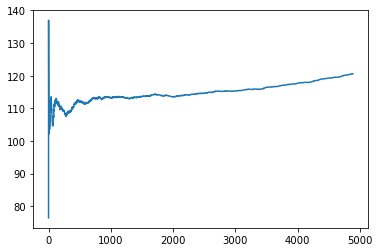

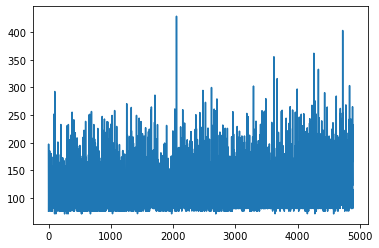

In [11]:
plt.show()
plt.plot(train_avg_ret)

plt.show()
plt.plot(train_ep_ret)

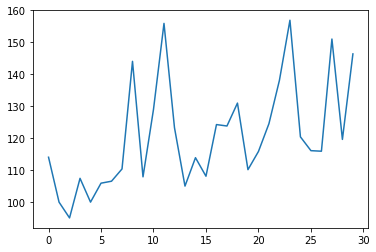

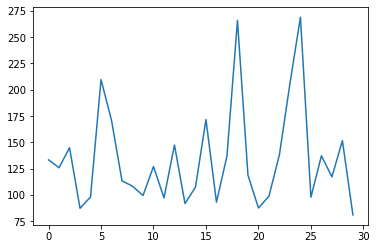

In [12]:
plt.show()
plt.plot(eval_avg_ret)

plt.show()
plt.plot(eval_ep_ret)